In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
import platform
from scipy.optimize import minimize
from numpy.linalg import inv
from scipy.sparse import diags
from scipy.linalg import block_diag
from joblib import Parallel, delayed
from tqdm import tqdm
# ephys funcs
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants
# import structures
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.eye_data import EyeData
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
# parallel
from joblib import Parallel, delayed
from tqdm import tqdm
import glm_functions

### Functions

### Read data

In [2]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [3]:
# Load data
neu_path = basepath+"/session_struct/lip/neurons/2023-11-30_11-16-24_Riesling_lip_e1_r1_good1_neu.h5"#2023-11-30_11-16-24_Riesling_lip_e1_r1_good1   2023-12-06_11-17-19_Riesling_lip_e1_r1_good4
neu_data = NeuronData.from_python_hdf5(neu_path)

### Preproces data
* select trials 
* define stimulus
* define basis
* convole stimulus with its corresponding base -> desing matrix
* stack spikes and desing matrices

In [4]:
# parameters
time_before=0
select_block=1
# start=-200
# end=1200
# idx_start = time_before + start 
# idx_end = time_before+end

In [5]:
# Select trials aligned to start_trial
code=1
sp_sample_on,mask = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block= select_block,
    select_pos= code,
    event ="sample_on",
    time_before = time_before,
    error_type= 0,
)

### Define basis

In [6]:
# Number of basis for each stimulus
fix_cue_dim=4
fixation_dim=5
sample_dim=15
delay_dim=15
test_dim=10
match_dim=4
bar_dim=4
hist_cos_dim = 10
hist_box_dim = 10
hist_dim = hist_cos_dim+hist_box_dim
# Compute basis
cos_basis=glm_functions.make_non_linear_raised_cos(nBases=hist_cos_dim, binSize=1, endPoints=np.array([10,150]), nlOffset=1)
single_bin_boxcars = np.zeros((cos_basis.shape[0],hist_box_dim))
single_bin_boxcars[range(hist_box_dim),range(hist_box_dim)]=1
hist_basis = np.concatenate((single_bin_boxcars,cos_basis),axis=1)
fix_cue_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=fix_cue_dim,duration=500)
fixation_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=fixation_dim,duration=1200)
sample_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=sample_dim,duration=400)
delay_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=delay_dim,duration=400)
test_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=test_dim,duration=400)
match_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=match_dim,duration=400)
bar_release_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=bar_dim,duration=80)
basis={'fix_cue':fix_cue_basis,'fixation':fixation_basis,'hist':hist_basis,
       's_on_off':[np.nan],
       's_o1':sample_basis,'s_o5':sample_basis,
       's_c1':sample_basis,'s_c5':sample_basis,'s_n0':sample_basis,
       'd_o1':delay_basis,'d_o5':delay_basis,'d_c1':delay_basis,'d_c5':delay_basis,'d_n0':delay_basis,'d_on_off':[np.nan]}
for i in range(1,9):
    basis['test_color'+str(i)] = test_basis
    basis['test_orient'+str(i)] = test_basis
for i in range(1,5):
    basis['test_on_off'+str(i)] = [np.nan]
basis['match'] = match_basis
basis['bar_release'] = bar_release_basis

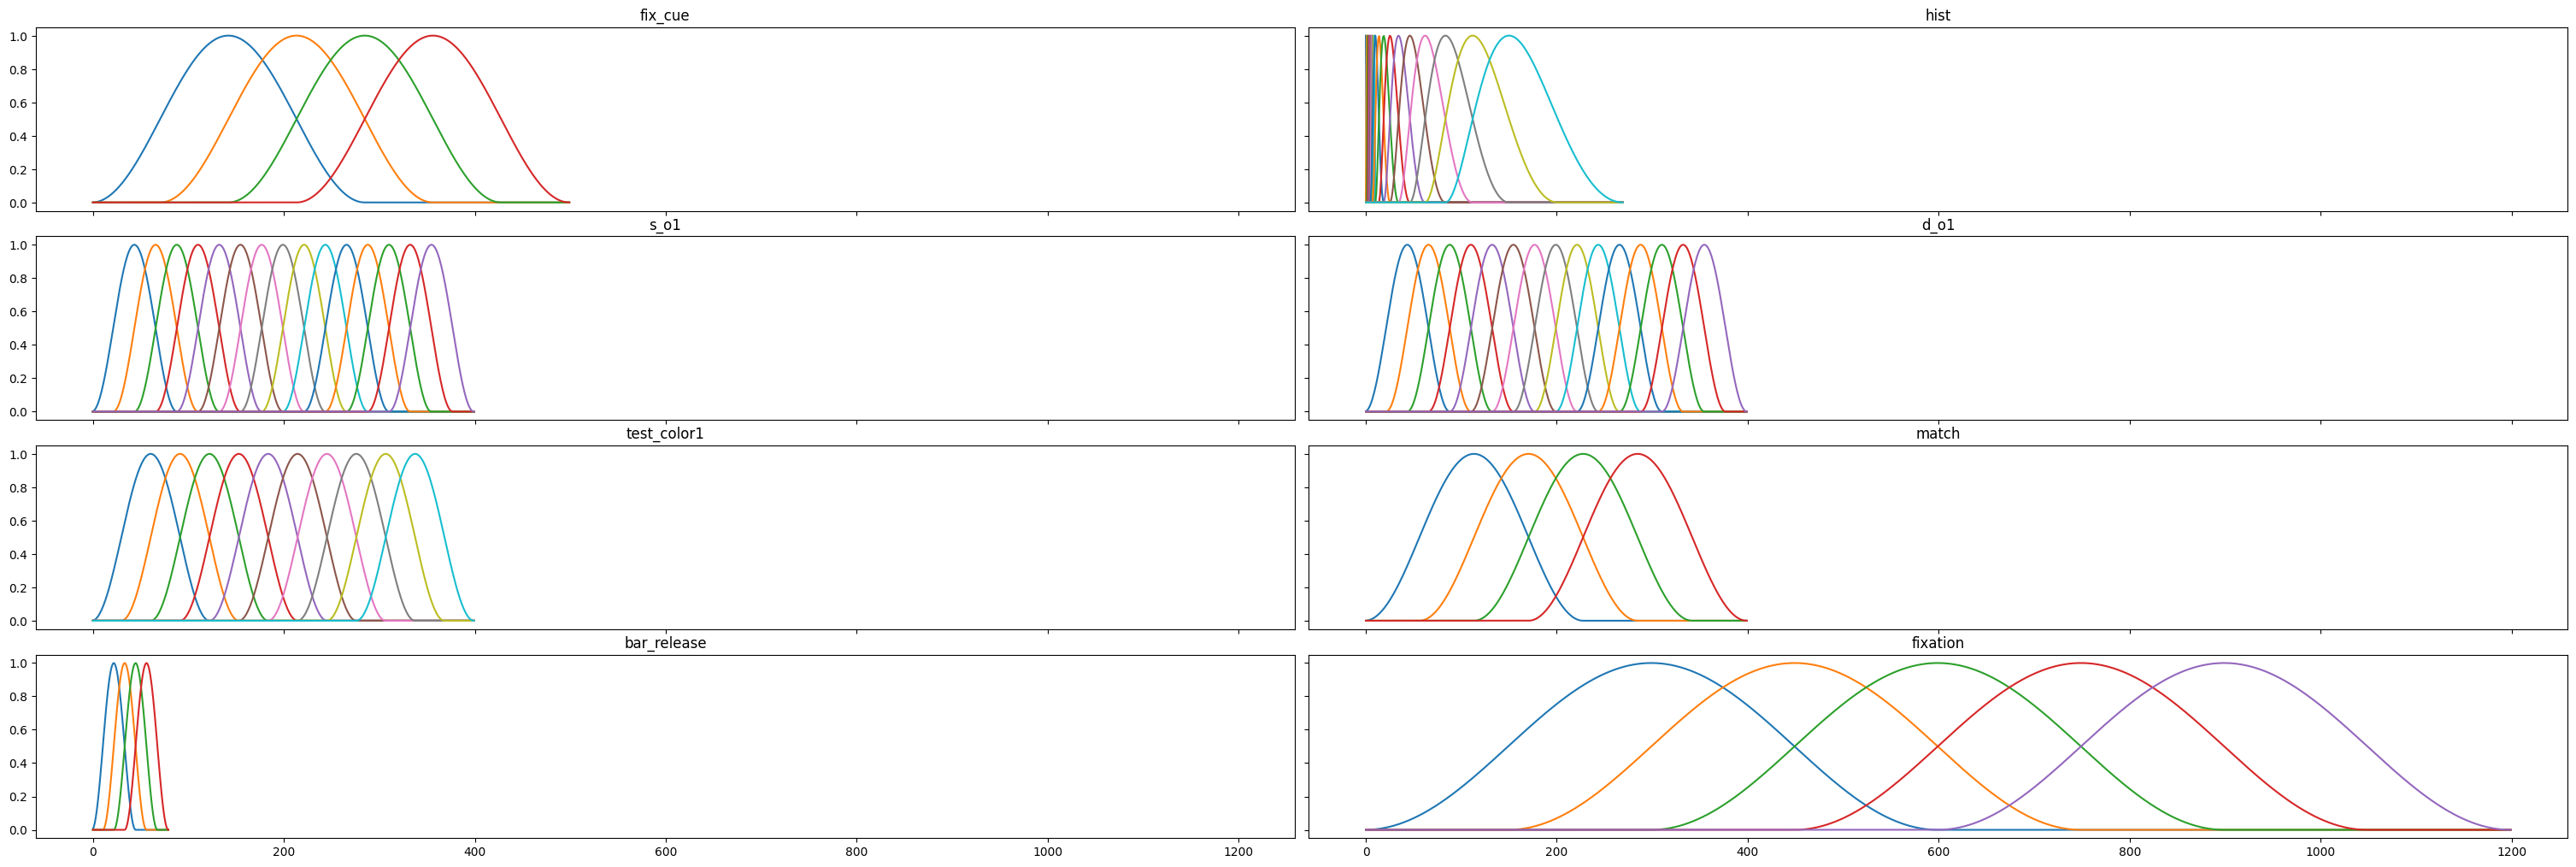

In [7]:
# print filters
basis_keys = ['fix_cue', 'hist', 's_o1', 'd_o1', 'test_color1', 'match', 'bar_release','fixation']
cols = 2
rows = len(basis_keys)//cols
rows =rows +1 if len(basis_keys)%cols>0 else rows
f,ax=plt.subplots(rows,cols,figsize=(30,10),sharey=True,sharex=True)
for iax,var in zip(np.concatenate(ax),basis_keys):
    iax.plot(basis[var])
    iax.set_title(var)
f.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)

### Compute desing matrix

In [8]:
# iterate over trials
def get_dm(i_tr):

    e_time = neu_data.code_samples[mask][i_tr]-neu_data.code_samples[mask][i_tr][4]+time_before
    e_code = neu_data.code_numbers[mask][i_tr]
    test_stimuli = neu_data.test_stimuli[mask][i_tr]
    # n_test=np.sum(~np.isnan(test_stimuli))
    reward = task_constants.EVENTS_B1[last_event]
    idx_last = np.where(e_code==reward)[0]

    len_tr=int(e_time[idx_last][0]+10)
    sample_id = neu_data.sample_id[mask][i_tr]
    stim = glm_functions.def_stim(events,len_tr,e_time,e_code,sample_id,sp_sample_on[i_tr,:len_tr],test_stimuli)
    all_dm = {}
    indices = {}
    design_mat=np.zeros((len_tr,1))
    shape = 0
    for key in events:
        base=basis[key]
        if np.any(np.isnan(base)):
            all_dm[key]=stim[key][:,np.newaxis]
        else:
            sb_conv = signal.convolve2d(stim[key][:,np.newaxis],base)
            all_dm[key]=sb_conv[:len_tr]
        indices[key]=[shape,shape+all_dm[key].shape[1]]
        shape = shape+all_dm[key].shape[1]
        design_mat = np.concatenate((design_mat,all_dm[key]), axis=1)

    return {"design_mat":design_mat[:,1:],"all_dm":all_dm,"stim":stim,"len_tr":len_tr,"s_on":e_time[4],"fix_on":e_time[2],"delay_on":e_time[5],"test1_on":e_time[6],"indices":indices,"sp":sp_sample_on[i_tr,:len_tr]}


In [9]:
events = [
    # "fix_cue",
    # "fixation",
    "hist",
    "s_o1",
    "s_o5",
    "s_c1",
    "s_c5",
    "s_n0",
    "s_on_off",
    "d_o1",
    "d_o5",
    "d_c1",
    "d_c5",
    "d_n0",
    "d_on_off",
    # "test_orient1",
    # "test_orient2",
    # "test_orient3",
    # "test_orient4",
    # "test_orient5",
    # "test_orient6",
    # "test_orient7",
    # "test_orient8",
    # "test_color1",
    # "test_color2",
    # "test_color3",
    # "test_color4",
    # "test_color5",
    # "test_color6",
    # "test_color7",
    # "test_color8",
    # "match",
    # "bar_release",
]
last_event = "test_on_1"#"reward"

In [10]:
sample_id=neu_data.sample_id[mask]
sn0= np.where(sample_id== 0)[0][:10]
s15= np.where(sample_id== 15)[0][:10]
s11= np.where(sample_id== 11)[0][:10]
s55= np.where(sample_id== 55)[0][:10]
s51= np.where(sample_id== 51)[0][:10]
idxs_train =np.concatenate((sn0,s15,s11,s55,s51))
rng = np.random.default_rng(seed=2024)
rng.shuffle(idxs_train)

sample_id=neu_data.sample_id[mask]
sn0= np.where(sample_id== 0)[0][15:20]
s15= np.where(sample_id== 15)[0][15:20]
s11= np.where(sample_id== 11)[0][15:20]
s55= np.where(sample_id== 55)[0][15:20]
s51= np.where(sample_id== 51)[0][15:20]
idxs_test =np.concatenate((sn0,s15,s11,s55,s51))
rng = np.random.default_rng(seed=2024)
rng.shuffle(idxs_test)
idxs_test
idxs = np.concatenate((idxs_train,idxs_test))

In [11]:
n_tr,_ = sp_sample_on.shape
data    =   Parallel(n_jobs = -1)(delayed(get_dm)(i_tr) for i_tr in tqdm(idxs))

100%|██████████| 75/75 [00:32<00:00,  2.30it/s]


In [12]:
design_mat = []
all_dm =[]
all_len_tr = []
all_s_on = []
all_fix_on=[]
all_stim=[]
all_sp = []
all_d_on=[]
all_test1_on=[]
for asc in data:
    design_mat.append(asc["design_mat"])
    all_dm.append(asc["all_dm"])
    all_len_tr.append(asc["len_tr"])
    all_s_on.append(asc["s_on"])
    all_fix_on.append(asc["fix_on"])
    all_d_on.append(asc["delay_on"])
    all_stim.append(asc["stim"])
    all_sp.append(asc["sp"])
    all_test1_on.append(asc["test1_on"])
indices= data[0]["indices"]

In [13]:
n_train_tr = len(idxs_train)#int(100*0.490)
n_train_tr

50

In [14]:
# train
sp_train=np.concatenate(all_sp[:n_train_tr])
print("Length of all trials concatenated: %s"%sp_train.shape)
dm_train=np.concatenate(design_mat[:n_train_tr])
print("Shape of dm: (%s, %s)"%dm_train.shape)
len_tr_train=np.array(all_len_tr)[:n_train_tr]
print("Number of trials %s"%len_tr_train.shape)
s_on_train=np.array(all_s_on)[:n_train_tr]
fix_on_train=np.array(all_fix_on)[:n_train_tr]
d_on_train=np.array(all_d_on)[:n_train_tr]
test1_on_train=np.array(all_test1_on)[:n_train_tr]
# test 
sp_test=np.concatenate(all_sp[n_train_tr:])
print("Length of all trials concatenated: %s"%sp_test.shape)
dm_test=np.concatenate(design_mat[n_train_tr:])
print("Shape of dm: (%s, %s)"%dm_test.shape)
len_tr_test=np.array(all_len_tr)[n_train_tr:]
print("Number of trials %s"%len_tr_test.shape)
s_on_test=np.array(all_s_on)[n_train_tr:]
fix_on_test=np.array(all_fix_on)[n_train_tr:]
d_on_test=np.array(all_d_on)[n_train_tr:]
test1_on_test=np.array(all_test1_on)[n_train_tr:]

Length of all trials concatenated: 56409
Shape of dm: (56409, 172)
Number of trials 50
Length of all trials concatenated: 28185
Shape of dm: (28185, 172)
Number of trials 25


In [15]:
x=dm_train
mu = np.mean(x,axis=0)
sigma = np.std(x,axis=0)
sigma0 = sigma
sigma0[sigma0==0] = 1
dm_train = (x-mu) / sigma0

x=dm_test
mu = np.mean(x,axis=0)
sigma = np.std(x,axis=0)
sigma0 = sigma
sigma0[sigma0==0] = 1
dm_test = (x-mu) / sigma0

In [16]:
T,nreg=dm_train.shape
design_mat_offset = np.hstack((np.ones((T,1)), dm_train))  

In [50]:
#Fit poisson GLM using ML
T,_=dm_train.shape
design_mat_offset = np.hstack((np.ones((T,1)), dm_train))#dm_train))     # add a column of ones
#design_mat_offset = np.array(design_mat_offset,dtype=np.float128)
# Get the MLE weights for the model (Linear Gaussian GLM)
lg_weights = np.linalg.inv(design_mat_offset.T @ design_mat_offset) @ design_mat_offset.T @ sp_train
lg_weights=np.zeros(lg_weights.shape)
dt_fine=1
# -- Make loss functions and minimize -----
loss_func = lambda prs : glm_functions.neg_log_lik_lnp(prs, design_mat_offset, sp_train, dt_fine, vals_to_return=0)
grad_func = lambda prs : glm_functions.neg_log_lik_lnp(prs, design_mat_offset, sp_train, dt_fine, vals_to_return=1)
# hess_func = lambda prs : glm_functions.neg_log_lik_lnp(prs, design_mat_offset, sp_train, dt_fine, vals_to_return=2)
optimizer = minimize(fun=loss_func, x0=lg_weights, jac=grad_func, method='CG', options={'disp':True, 'gtol':1e-2, 'maxiter': 30})#hess=hess_func
filt_ML = optimizer.x

         Current function value: 5894.370109
         Iterations: 30
         Function evaluations: 49
         Gradient evaluations: 49


In [52]:
optimizer

 message: Maximum number of iterations has been exceeded.
 success: False
  status: 1
     fun: 5894.3701093402615
       x: [-4.190e+00 -6.429e-01 ... -1.893e-02  9.767e-02]
     nit: 30
     jac: [ 3.647e+00 -2.166e+00 ...  1.215e+00  3.039e+01]
    nfev: 49
    njev: 49

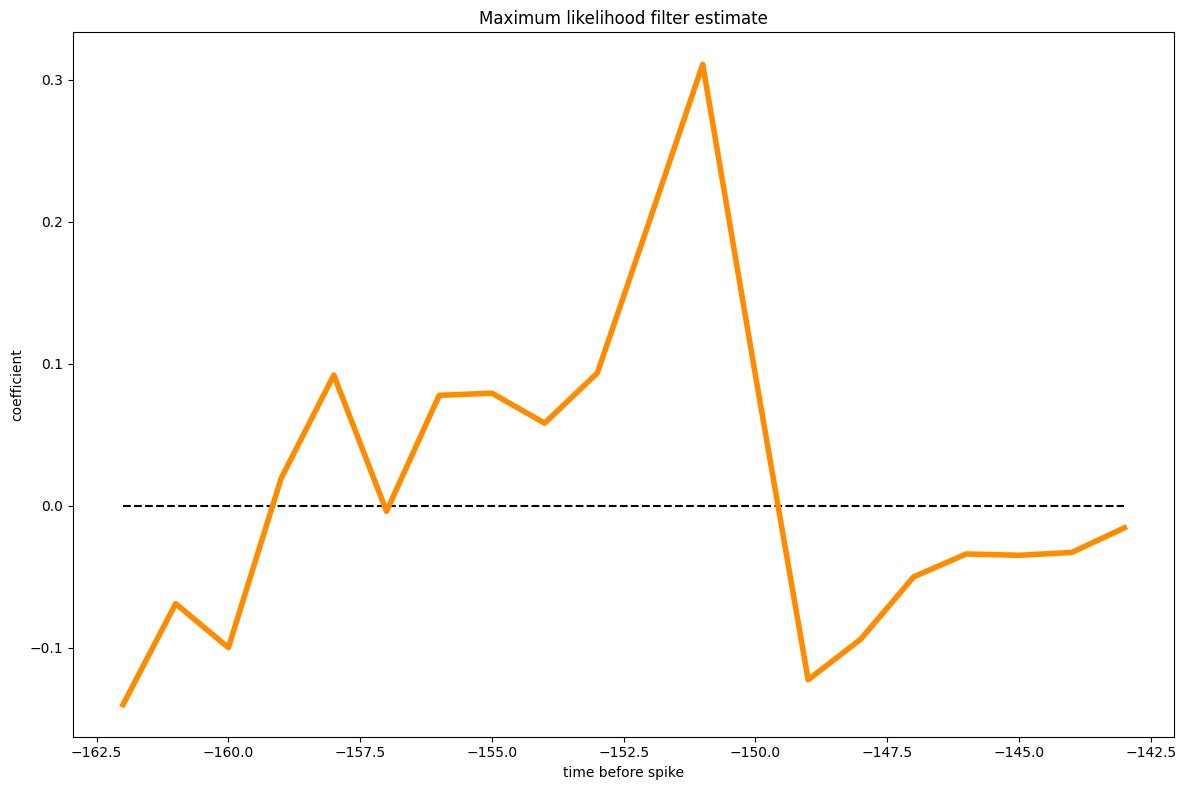

In [73]:
ntfilt=design_mat_offset.shape[1]
ttk = np.arange(-ntfilt, 0)*dt_fine
fig = plt.figure(figsize=[12,8])
plt.plot(ttk[11:31], ttk[11:31]*0, c='k', linestyle='--')
plt.plot(ttk[11:31],filt_ML[11:31], c='darkorange', linewidth=4)
plt.xlabel('time before spike')
plt.ylabel('coefficient')
plt.title('Maximum likelihood filter estimate')
plt.tight_layout()
plt.show()

In [118]:
# np.save('filt_ML',filt_ML)

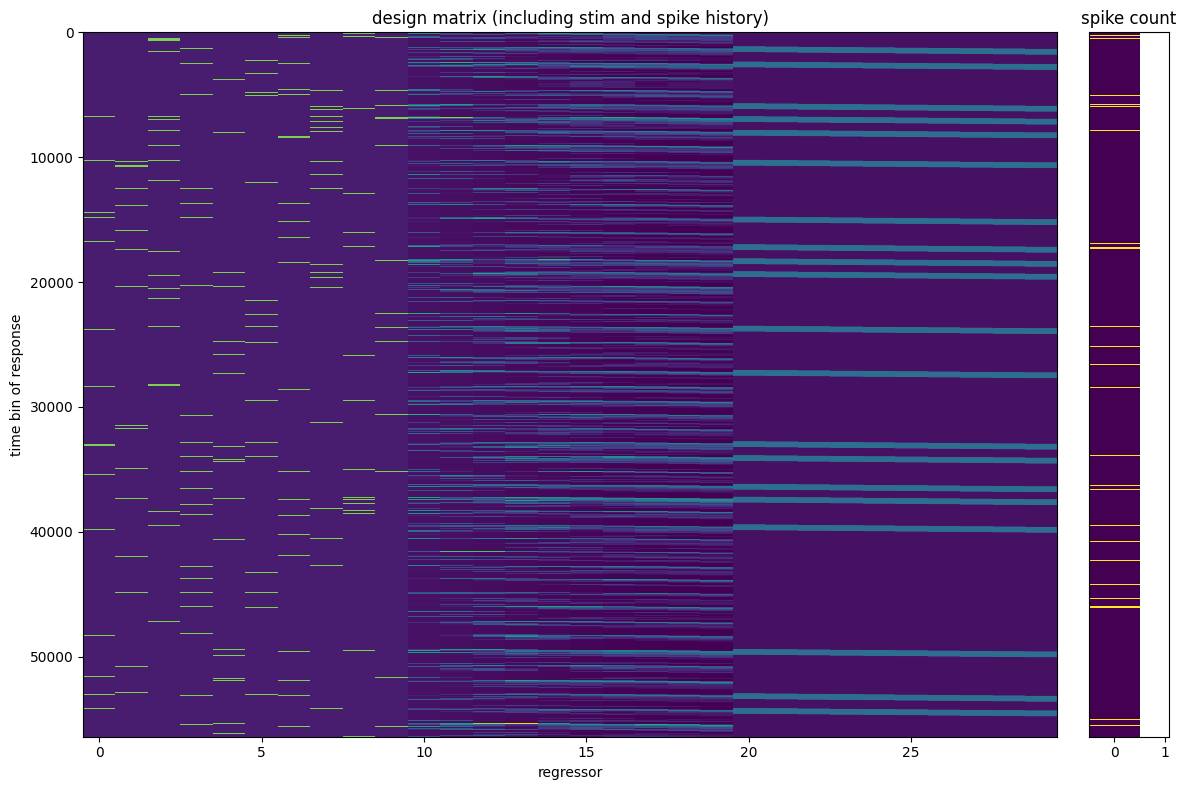

In [23]:
t_train,_=dm_train.shape

#dm_train_offset = np.hstack((np.ones((t_train,1)), dm_train))  
fig = plt.figure(figsize=[12,8])
plt.subplot(1,10,(1,9))
plt.imshow(dm_train[:,:30], aspect='auto', interpolation='nearest')
plt.hlines(8,0,29)
plt.xlabel('regressor')
plt.ylabel('time bin of response')
plt.title('design matrix (including stim and spike history)')
plt.subplot(1,10,10)
plt.imshow(sp_train[:,np.newaxis], aspect='auto', interpolation='nearest')
plt.yticks(ticks=[], labels=[])
plt.title('spike count')
plt.tight_layout()
plt.hlines(8,0,1)
plt.show()

### L2 regularization

In [62]:
def get_w_ridge(idx, lam):
    print('lambda: ' + str(lam))
    # Compute ridge-penalized MAP estimate
    Cinv = lam*Imat # set inverse prior covariance
    loss_post_func = lambda prs : glm_functions.neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=0)
    grad_post_func = lambda prs : glm_functions.neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=1)
    hess_post_func = lambda prs : glm_functions.neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=2)
    optimizer = minimize(fun=loss_post_func, x0=lg_weights, jac=grad_func, method='CG', options={'disp':True, 'gtol':1e-2, 'maxiter': 30})
    wmap = optimizer.x
    print(optimizer.success)
    # Compute negative logli
    negLtrain_idx = neg_log_lik_lnp(wmap, dm_train_offset, sp_train,dt_fine,  vals_to_return=0)
    negLtest_idx = neg_log_lik_lnp(wmap, dm_test_offset, sp_test, dt_fine, vals_to_return=0) # test loss

    # store the filter
    w_ridge_idx = wmap
    

    return {"negLtrain":negLtrain_idx,"negLtest":negLtest_idx,"w_ridge":w_ridge_idx}

In [17]:
import numpy as np
np.arange(0,1,1/100000)[np.arange(0,11000,100)]

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
       0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
       0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
       0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
       0.099, 0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107,
       0.108, 0.109])

In [18]:
from sklearn.model_selection import KFold

In [125]:
dm_train_offset.shape

(92738, 127)

In [77]:
t_train,_=dm_train.shape
t_test,_=dm_test.shape
dm_train_offset = np.hstack((np.ones((t_train,1)), dm_train))     # add a column of ones
dm_test_offset =np.hstack((np.ones((t_test,1)), dm_test))   
lg_weights = np.linalg.inv(dm_train_offset.T @ dm_train_offset) @ dm_train_offset.T @ sp_train# compute ML for initialization
lg_weights=np.zeros(lg_weights.shape)
dt_fine=1
lamvals = 2**np.arange(2) # it's common to use a log-spaced set of values
nlam = len(lamvals)
ntfilt=dm_train_offset.shape[1]
# Precompute some quantities for training and test data
Imat = np.identity(ntfilt) # identity matrix of size of filter + const
Imat[0,0] = 0 # remove penalty on constant dc offset
# Allocate space for train and test errors
negLtrain = np.zeros(nlam)  # training error
negLtest = np.zeros(nlam)   # test error
w_ridge = np.zeros((ntfilt, nlam)) # filters for each lambda
optimizer_res= []
# Define train and test log-likelihood funcs
neglogli_train_func = lambda prs : glm_functions.neg_log_lik_lnp(prs, dm_train_offset, sp_train, dt_fine)
# Now compute MAP estimate for each ridge parameter
wmap = lg_weights # initialize parameter estimate
n_tr,_ = sp_sample_on.shape
# data    =   Parallel(n_jobs = -1)(delayed(get_w_ridge)(idx, lam) for (idx, lam) in tqdm(enumerate(lamvals)))
# negLtrain_reg = []
# negLtest_reg = []
# w_ridge = []
# for asc in data:
#     negLtrain_reg.append(asc["negLtrain"])
#     negLtest_reg.append(asc["negLtest"])
#     w_ridge.append(asc["w_ridge"])
for idx, lam in enumerate(lamvals):
    print('lambda: ' + str(lam))
    # Compute ridge-penalized MAP estimate
    Cinv = lam*Imat # set inverse prior covariance
    loss_post_func = lambda prs : glm_functions.neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=0)
    grad_post_func = lambda prs : glm_functions.neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=1)
    hess_post_func = lambda prs : glm_functions.neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=2)
    optimizer = minimize(fun=loss_post_func, x0=lg_weights, jac=grad_func, method='CG', options={'disp':True, 'gtol':1e-2, 'maxiter': 30})#minimize(fun=loss_post_func, x0=wmap, method='trust-ncg', jac=grad_post_func, hess=hess_post_func, tol=1e-6, options={'disp':False, 'maxiter': 100})#
    wmap = optimizer.x
    print(optimizer.success)
    # Compute negative logli
    negLtrain[idx] = glm_functions.neg_log_lik_lnp(wmap, dm_train_offset, sp_train,dt_fine,  vals_to_return=0)
    negLtest[idx] = glm_functions.neg_log_lik_lnp(wmap, dm_test_offset, sp_test, dt_fine, vals_to_return=0) # test loss
    print(negLtrain[idx])
    # store the filter
    w_ridge[:,idx] = wmap
    
#     # plot it
#     plt.plot(ttk[:1], wmap[1:], linewidth=2, label='lambda: ' + str(lam))
# plt.legend()
# plt.tight_layout()
# plt.show()

lambda: 1
         Current function value: 5885.244625
         Iterations: 30
         Function evaluations: 54
         Gradient evaluations: 54
False
5883.568059048159
lambda: 2
         Current function value: 5912.349513
         Iterations: 30
         Function evaluations: 52
         Gradient evaluations: 52
False
5909.590758736619


In [74]:
ttk.shape

(173,)

In [72]:
wmap[1:].shape

(172,)

In [79]:
negLtrain_reg=np.array(negLtrain_reg)
negLtest_reg=np.array(negLtest_reg)
w_ridge=np.array(w_ridge).T

NameError: name 'negLtrain_reg' is not defined

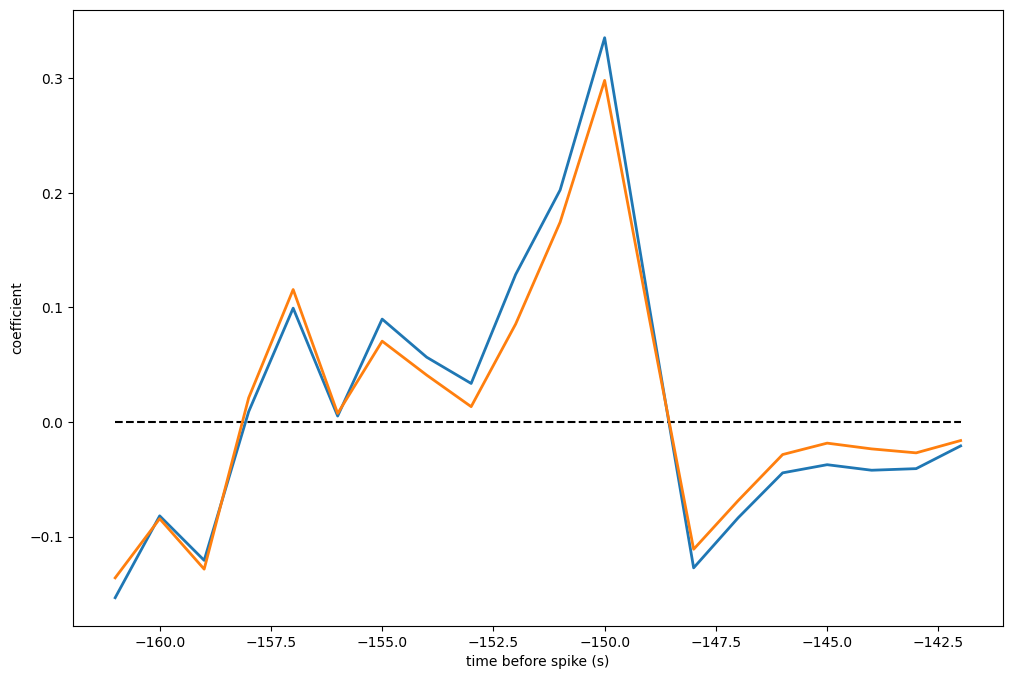

In [80]:
fig = plt.figure(figsize=[12,8])
ttk = np.arange(-ntfilt+1, 0)*dt_fine
plt.plot(ttk[11:31], ttk[11:31]*0, c='k', linestyle='--')
plt.ylabel('coefficient')
plt.xlabel('time before spike (s)')
for i,i_l in enumerate(lamvals):
    # plot it
    plt.plot(ttk[11:31], w_ridge[11:31,i], linewidth=2, label='lambda: ' + str(i_l))

In [ ]:
w_ridge[1:,:].shape

(130, 20)

NameError: name 'negLtrain_reg' is not defined

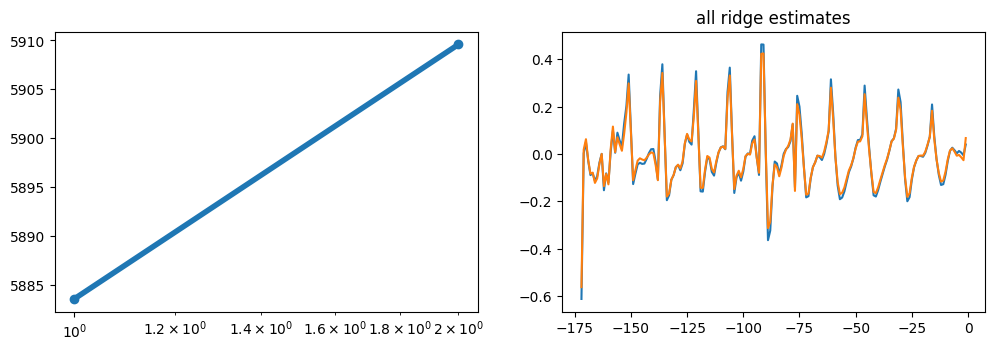

In [83]:
### ===== Plot filter estimates and errors for ridge estimates =====
imin = 0#np.argmin(negLtest_reg)
fig = plt.figure(figsize=[12,8])
plt.subplot(222)
plt.plot(ttk, w_ridge[1:,:])
plt.title('all ridge estimates')
plt.subplot(221)
plt.semilogx(lamvals, negLtrain,'o-', linewidth=4)
plt.vlines(lamvals[imin],np.min(negLtrain_reg),np.max(negLtrain_reg),'k',linestyles=':')
plt.title('training logli')
plt.subplot(223)
plt.semilogx(lamvals, negLtest,'-o', linewidth=4)
plt.vlines(lamvals[imin],np.min(negLtest_reg),np.max(negLtest_reg),'k',linestyles=':')
plt.xlabel('lambda')
plt.title('test logli')

# Notice that training error gets monotonically worse as we increase lambda
# However, test error has an dip at some optimal, intermediate value.

# Determine which lambda is best by selecting one with lowest test error 

filt_ridge = w_ridge[1:,imin]
plt.subplot(224)
#plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.plot(ttk[:20], filt_ridge[10:30], linewidth=4)
plt.xlabel('time before spike (s)')
plt.title('best ridge estimate (lamda: %d)'%lamvals[imin])

plt.tight_layout()
plt.show()

### L2 smoothing

lambda: 1
False
17706.758809404444
lambda: 2


KeyboardInterrupt: 

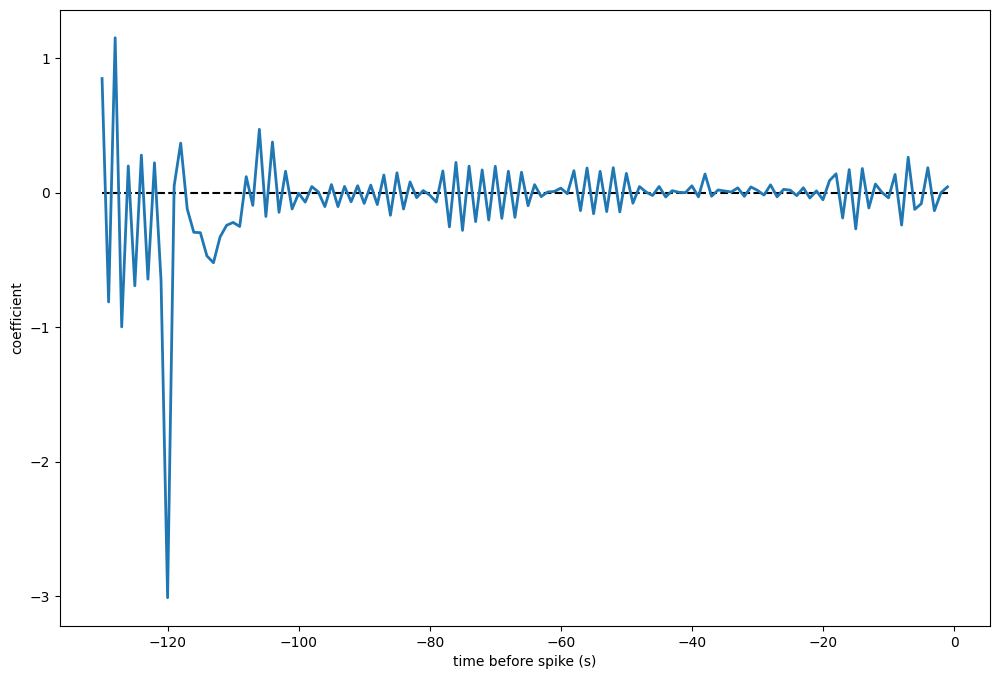

In [ ]:
t_train,_=dm_train.shape
t_test,_=dm_test.shape

dm_train_offset = np.hstack((np.ones((t_train,1)), dm_train))     # add a column of ones
dm_test_offset =np.hstack((np.ones((t_test,1)), dm_test))   
ntfilt=dm_train_offset.shape[1]
# This matrix computes differences between adjacent coeffs
Dx1 = diags((np.ones((ntfilt-1,1)) @ [[1,-1]]).T, np.arange(2), (ntfilt, ntfilt-1)).A
Dx = Dx1.T @ Dx1 # computes squared diffs
# Embed Dx matrix in matrix with one extra row/column for constant coeff
D = block_diag(0, Dx)
dt_fine=1
lamvals_sm = 2**np.arange(16) # it's common to use a log-spaced set of values
nlam = len(lamvals_sm)

# Precompute some quantities for training and test data
# Imat = np.identity(ntfilt) # identity matrix of size of filter + const
# Imat[0,0] = 0 # remove penalty on constant dc offset
# Allocate space for train and test errors
negLtrain_sm = np.zeros(nlam)  # training error
negLtest_sm = np.zeros(nlam)   # test error
w_smooth = np.zeros((ntfilt, nlam)) # filters for each lambda
optimizer_res= []
# Define train and test log-likelihood funcs
neglogli_train_func = lambda prs : neg_log_lik_lnp(prs, dm_train_offset, sp_train, dt_fine)
# Now compute MAP estimate for each ridge parameter
wmap = np.zeros(ntfilt)#lg_weights # initialize parameter estimate
fig = plt.figure(figsize=[12,8])
ttk = np.arange(-ntfilt+1, 0)*dt_fine
plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.ylabel('coefficient')
plt.xlabel('time before spike (s)')
for idx, lam in enumerate(lamvals_sm):
    print('lambda: ' + str(lam))
    # Compute ridge-penalized MAP estimate
    Cinv = lam*D # set inverse prior covariance
    loss_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=0)
    grad_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=1)
    hess_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=2)
    optimizer = minimize(fun=loss_post_func, x0=wmap, method='trust-ncg', jac=grad_post_func, hess=hess_post_func, tol=1e-6, options={'disp':False, 'maxiter': 100})
    wmap = optimizer.x
    print(optimizer.success)
    # Compute negative logli
    negLtrain_sm[idx] = neg_log_lik_lnp(wmap, dm_train_offset, sp_train,dt_fine,  vals_to_return=0)
    negLtest_sm[idx] = neg_log_lik_lnp(wmap, dm_test_offset, sp_test, dt_fine, vals_to_return=0) # test loss
    print(negLtrain_sm[idx])
    # store the filter
    w_smooth[:,idx] = wmap
    
    # plot it
    plt.plot(ttk, wmap[1:], linewidth=2, label='lambda: ' + str(lam))
plt.legend()
plt.tight_layout()
plt.show()

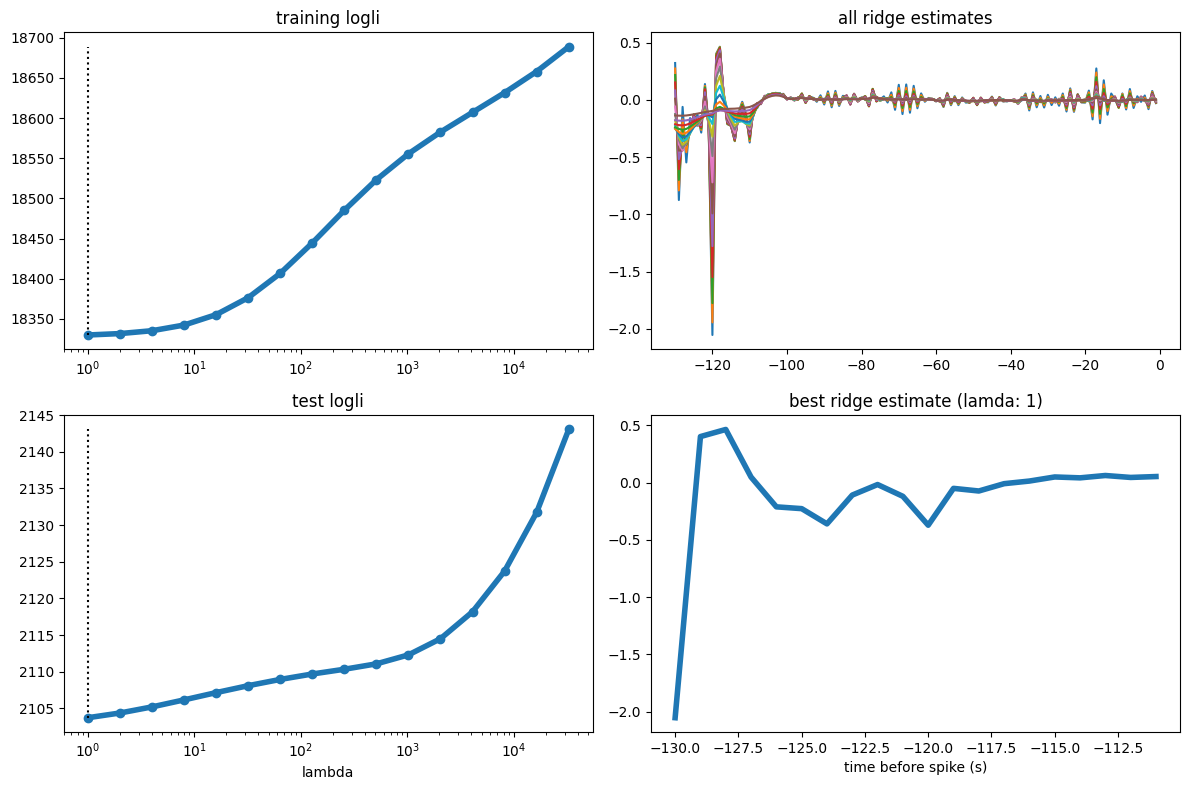

In [ ]:
### ===== Plot filter estimates and errors for ridge estimates =====
imin = np.argmin(negLtest_sm)
fig = plt.figure(figsize=[12,8])
plt.subplot(222)
plt.plot(ttk, w_smooth[1:,:])
plt.title('all ridge estimates')
plt.subplot(221)
plt.semilogx(lamvals_sm, negLtrain_sm,'o-', linewidth=4)
plt.vlines(lamvals_sm[imin],np.min(negLtrain_sm),np.max(negLtrain_sm),'k',linestyles=':')
plt.title('training logli')
plt.subplot(223)
plt.semilogx(lamvals_sm, negLtest_sm,'-o', linewidth=4)
plt.vlines(lamvals_sm[imin],np.min(negLtest_sm),np.max(negLtest_sm),'k',linestyles=':')
plt.xlabel('lambda')
plt.title('test logli')

# Notice that training error gets monotonically worse as we increase lambda
# However, test error has an dip at some optimal, intermediate value.

# Determine which lambda is best by selecting one with lowest test error 

filt_smooth = w_smooth[1:,imin]
plt.subplot(224)
#plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.plot(ttk[:20], filt_smooth[10:30], linewidth=4)
plt.xlabel('time before spike (s)')
plt.title('best ridge estimate (lamda: %d)'%lamvals_sm[imin])

plt.tight_layout()
plt.show()

In [ ]:
negLtest_sm

array([2103.72973212, 2104.37284128, 2105.20441456, 2106.16118559,
       2107.15209111, 2108.09792292, 2108.95184913, 2109.69154111,
       2110.33853882, 2111.07654897, 2112.2989378 , 2114.50583462,
       2118.17899924, 2123.72905376, 2131.7365751 , 2143.04272587])

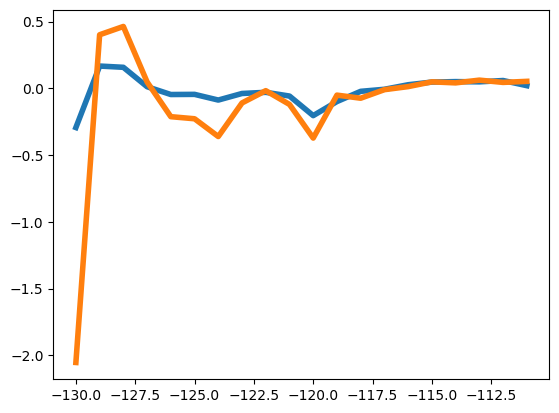

In [ ]:
plt.plot(ttk[:20], filt_ridge[10:30], linewidth=4)
plt.plot(ttk[:20], filt_smooth[10:30], linewidth=4)

In [77]:
dm_train.shape

(92738, 129)

In [78]:
weights.shape

(130,)

In [54]:
weights =filt_ML#w_ridge
#negLtrain= negLtrain_reg
#negLtest= negLtest_reg
rate_pred_train = np.exp(weights[0] + dm_train@ weights[1:]) 
rate_pred_test = np.exp(weights[0] + dm_test@ weights[1:]) #np.exp(weights[0,np.argmin(negLtrain)] + dm_train@ weights[1:,np.argmin(negLtrain)]) 

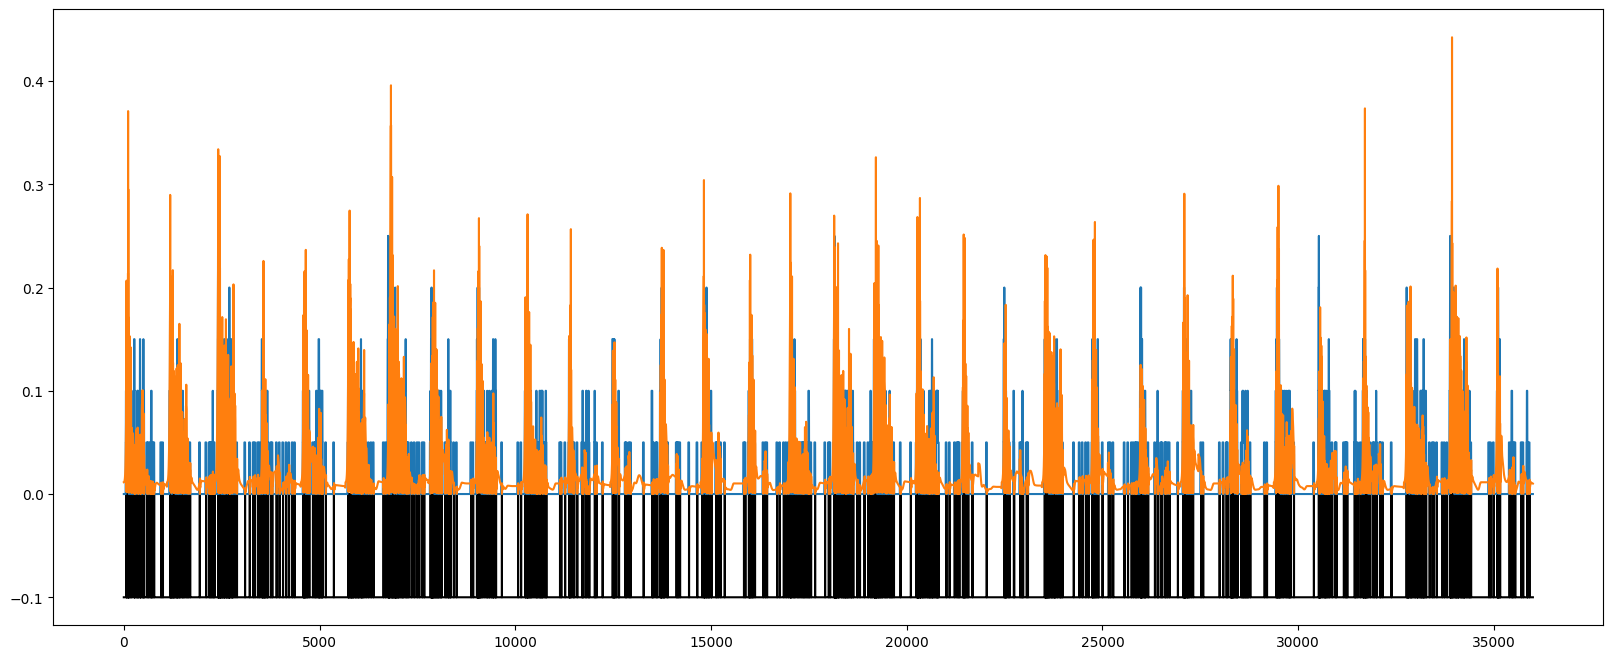

In [55]:
plt.subplots(figsize=(20,8))
plt.plot(sp_train[1:36000]/10-0.1,'k')
avg_sp_train = firing_rate.moving_average(data=sp_train[1:36000], win=20, step = 1)
plt.plot(avg_sp_train)
plt.plot(rate_pred_train[1:36000])

In [ ]:
design_mat_offset.shape

(32947, 583)

### Train and Test GLM model

In [56]:
# 0:const, 1:dm_fix, 2:dm_so1, 3:dm_so5,4:dm_sc1,5:dm_sc5,6:dm_sn0,7:dm_hist,8:sample_on_off,9:dm_do1,10:dm_do5,11:dm_dc1,12:dm_dc5,13:dm_dn0,14:delay_on_off
variables = list(indices.keys())
glm_vars = {}
glm_const = filt_ML[0]
glm_vars["glm_const"]=glm_const
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    glm_vars[var] = filt_ML[st+1:ed+1]

KeyError: 'test_orient1'

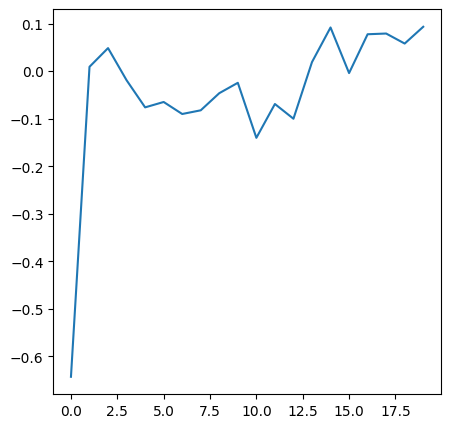

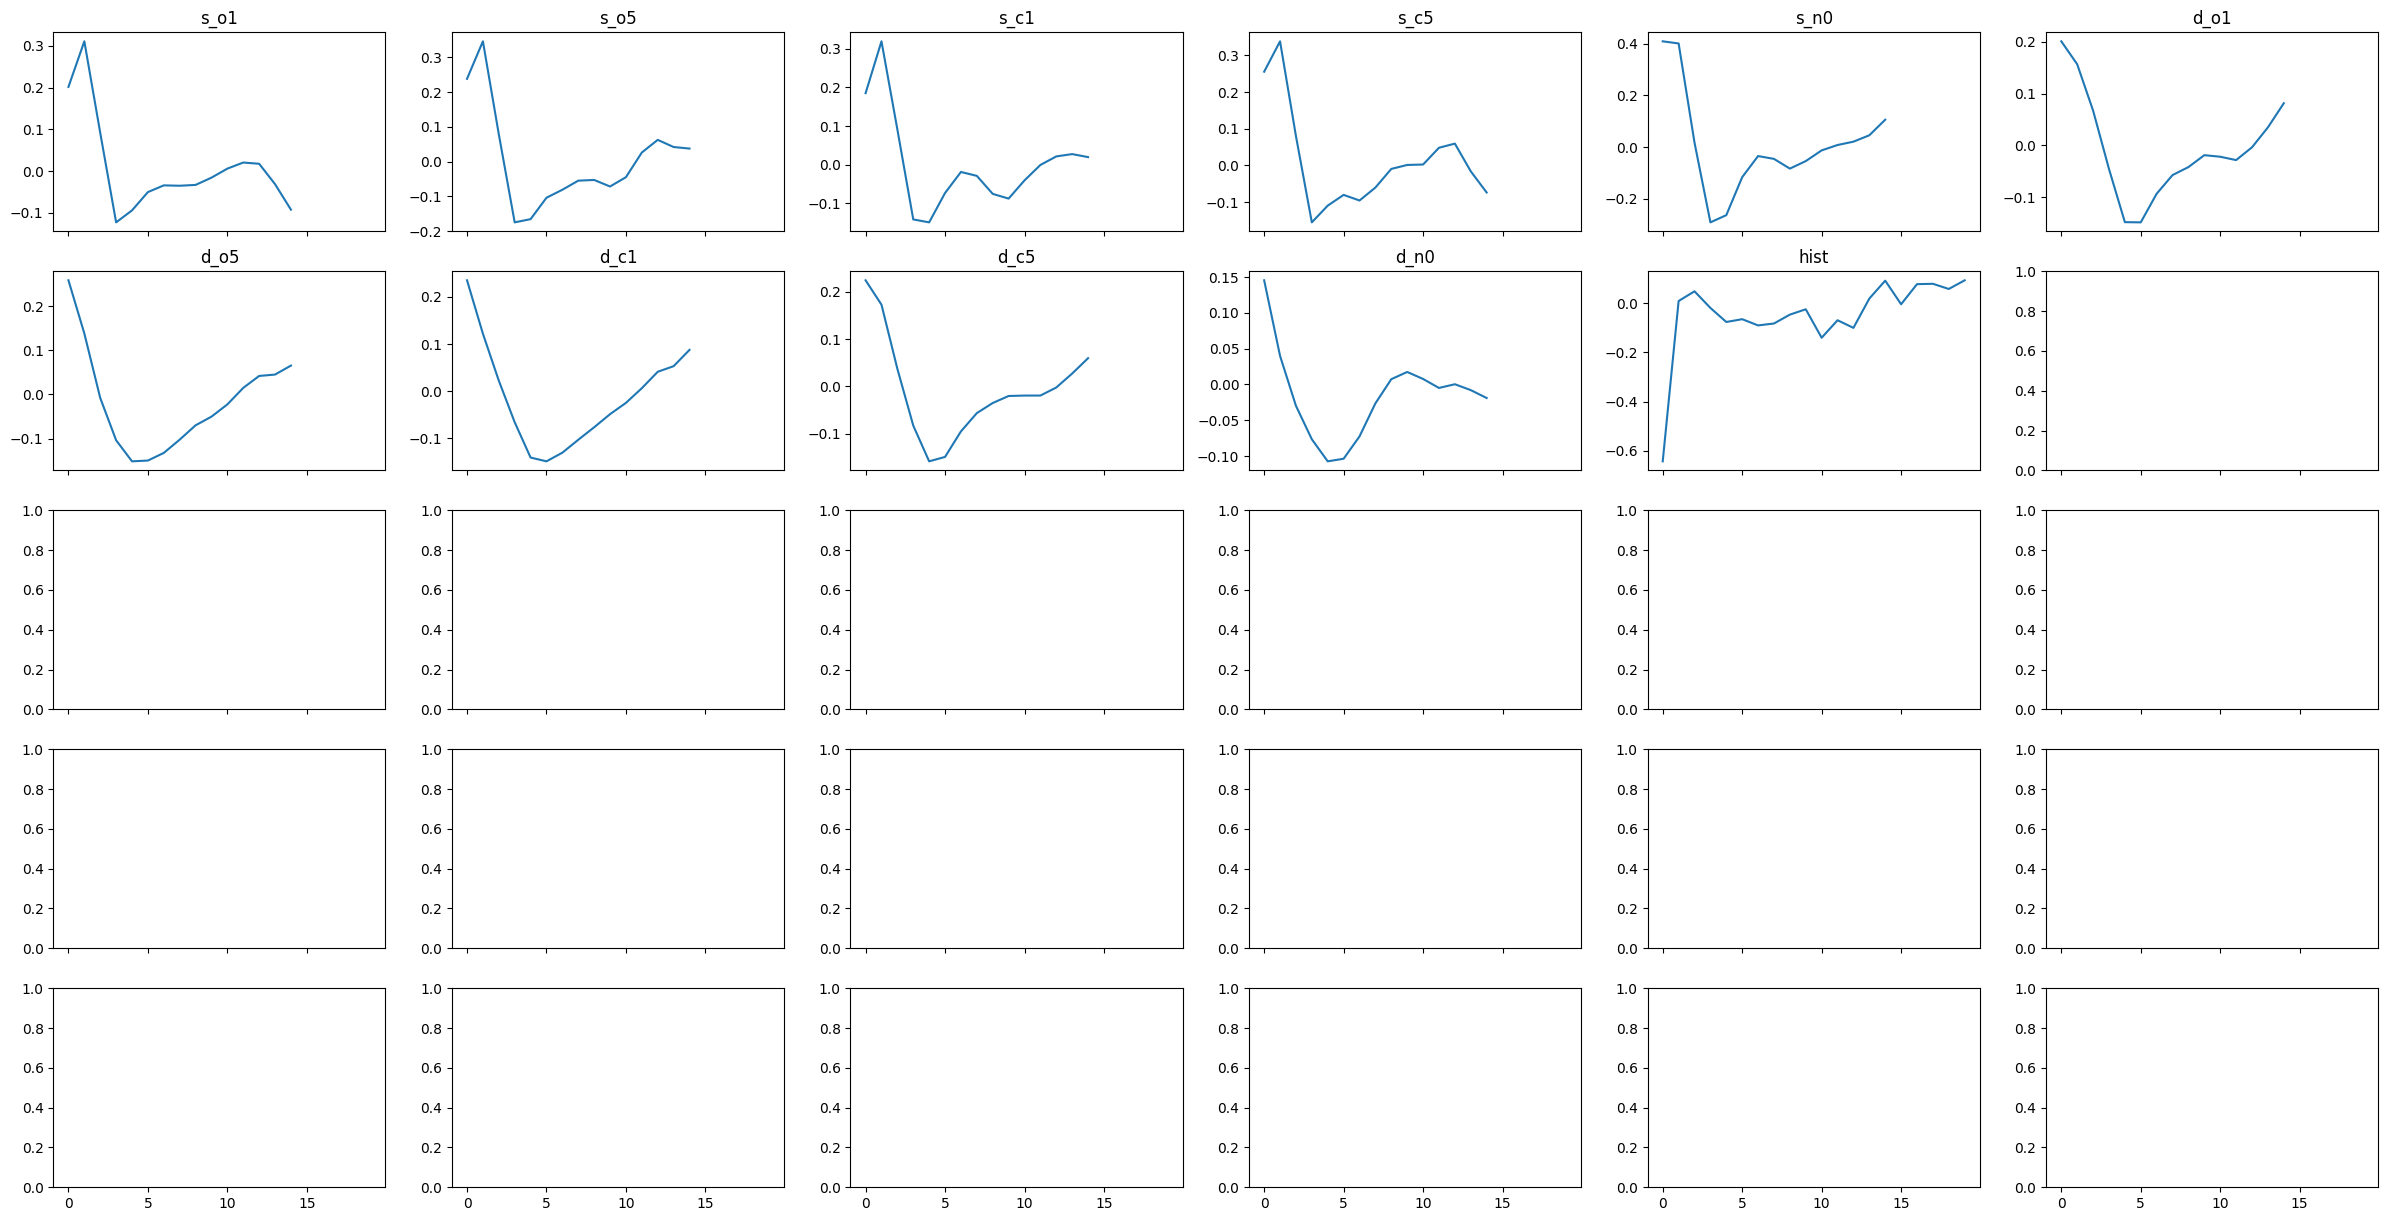

In [57]:
# print filters
f,ax=plt.subplots(figsize=(5,5))
ax.plot(glm_vars['hist'])
variables = [ 's_o1', 's_o5', 's_c1', 's_c5', 's_n0', 'd_o1', 'd_o5', 'd_c1', 'd_c5', 'd_n0','hist','test_orient1','test_orient2',  'test_orient3','test_orient4',  'test_orient5', 
              'test_orient6',  'test_orient7', 'test_orient8','test_color1','test_color2','test_color3', 'test_color4','test_color5','test_color6', 'test_color7', 'test_color8',   
             'match','bar_release']
cols = 6
rows = len(variables)//cols
rows =rows +1 if len(variables)%cols>0 else rows
f,ax=plt.subplots(rows,cols,figsize=(30,15),sharex=True)
for iax,var in zip(np.concatenate(ax),variables):
    iax.plot(glm_vars[var])
    iax.set_title(var)


In [ ]:
dm_train.shape

(85286, 132)

In [58]:
cumsum = np.cumsum(len_tr_train)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

In [34]:
dm_train.shape

(92738, 129)

In [84]:
indices['fix_cue'][0]

0

In [63]:
(np.array(dm_train[:,st:ed],dtype=np.float128 )@ glm_vars[''s_n0''])/10000000

array([-787.92888818, -787.92888818, -787.92888818, ..., -787.92888818,
       -787.92888818, -787.92888818], dtype=float128)

array([6.40961184e-343, 6.40961184e-343, 6.40961184e-343, ...,
       6.40961184e-343, 6.40961184e-343, 6.40961184e-343], dtype=float128)

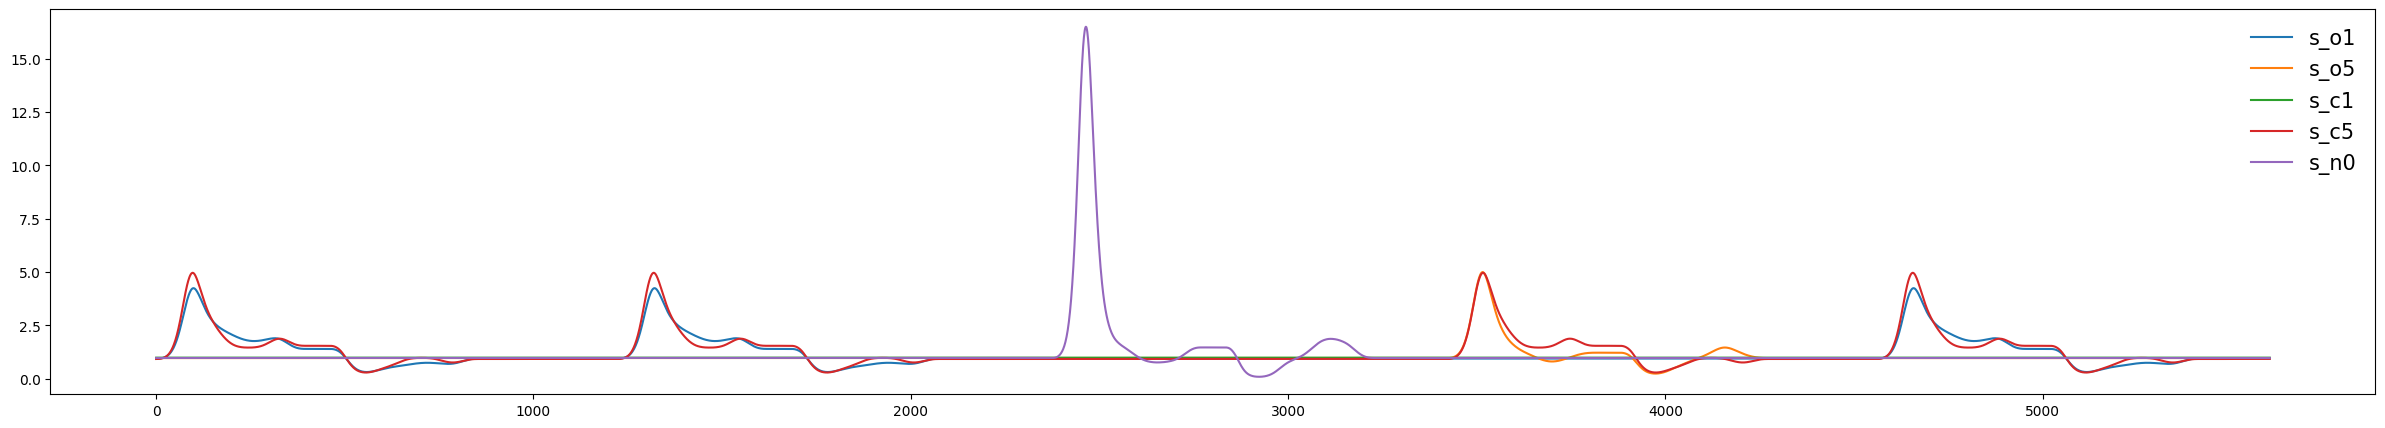

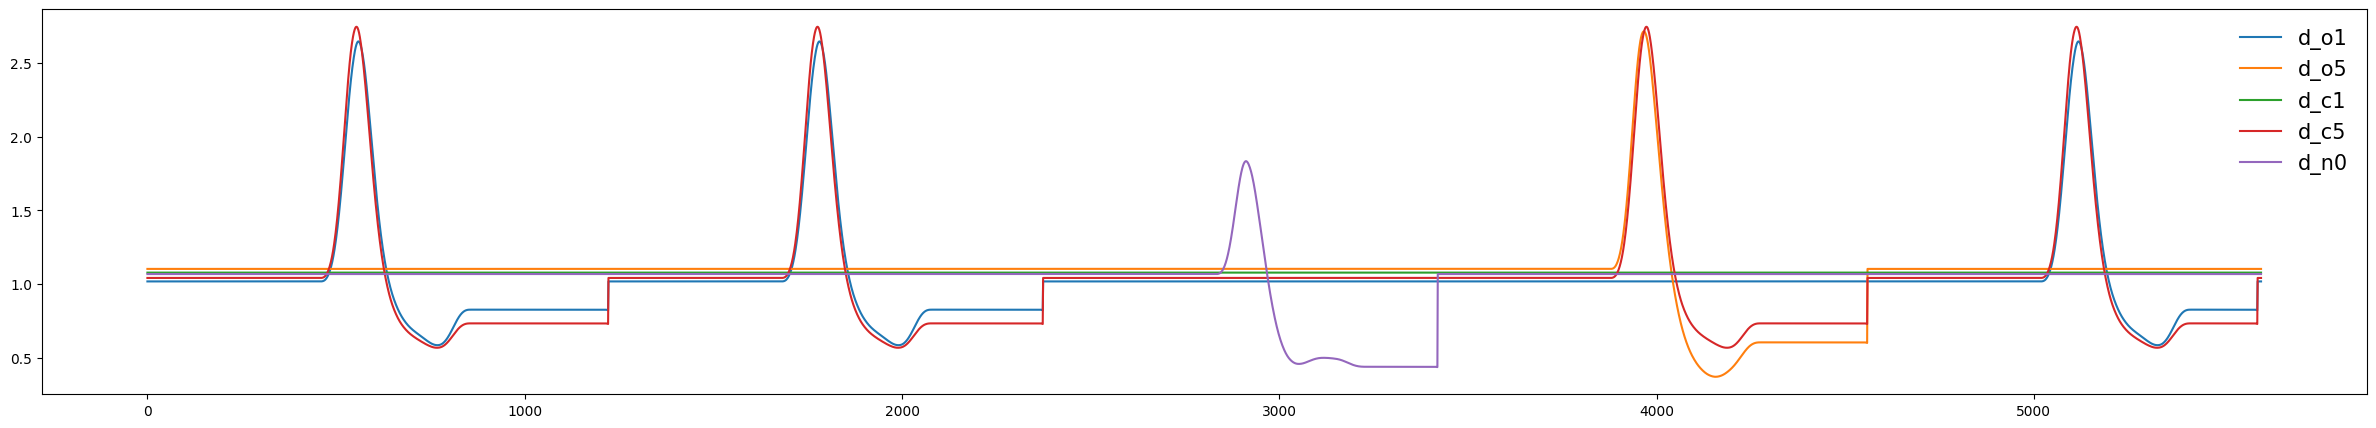

In [61]:
variables = [  's_o1', 's_o5', 's_c1', 's_c5', 's_n0']#'fix_cue',
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component= np.exp( dm_train[:,st:ed] @ glm_vars[var])
    #component = np.convolve(component, kernel, mode="same") 
    plt.plot(component[int(start[1]):end[5]+10],label = var)
# plt.vlines(s_on_train[0]-200,0.99,1.1,'r')
# plt.vlines(s_on_train[0],0.99,1.1,'k')
# plt.vlines(fix_on_train[0],0.99,1.1)
# plt.vlines(s_on_train[0]+450,0.99,1.1,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
variables = ['d_o1', 'd_o5', 'd_c1', 'd_c5', 'd_n0']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
    plt.plot(component[int(start[1]):end[5]+10],label = var)
# plt.vlines(s_on_train[0]-200,0.99,1.1,'r')
# plt.vlines(s_on_train[0],0.99,1.1,'k')
# plt.vlines(fix_on_train[0],0.99,1.1)
# plt.vlines(s_on_train[0]+450,0.99,1.1,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')



KeyError: 'test_color1'

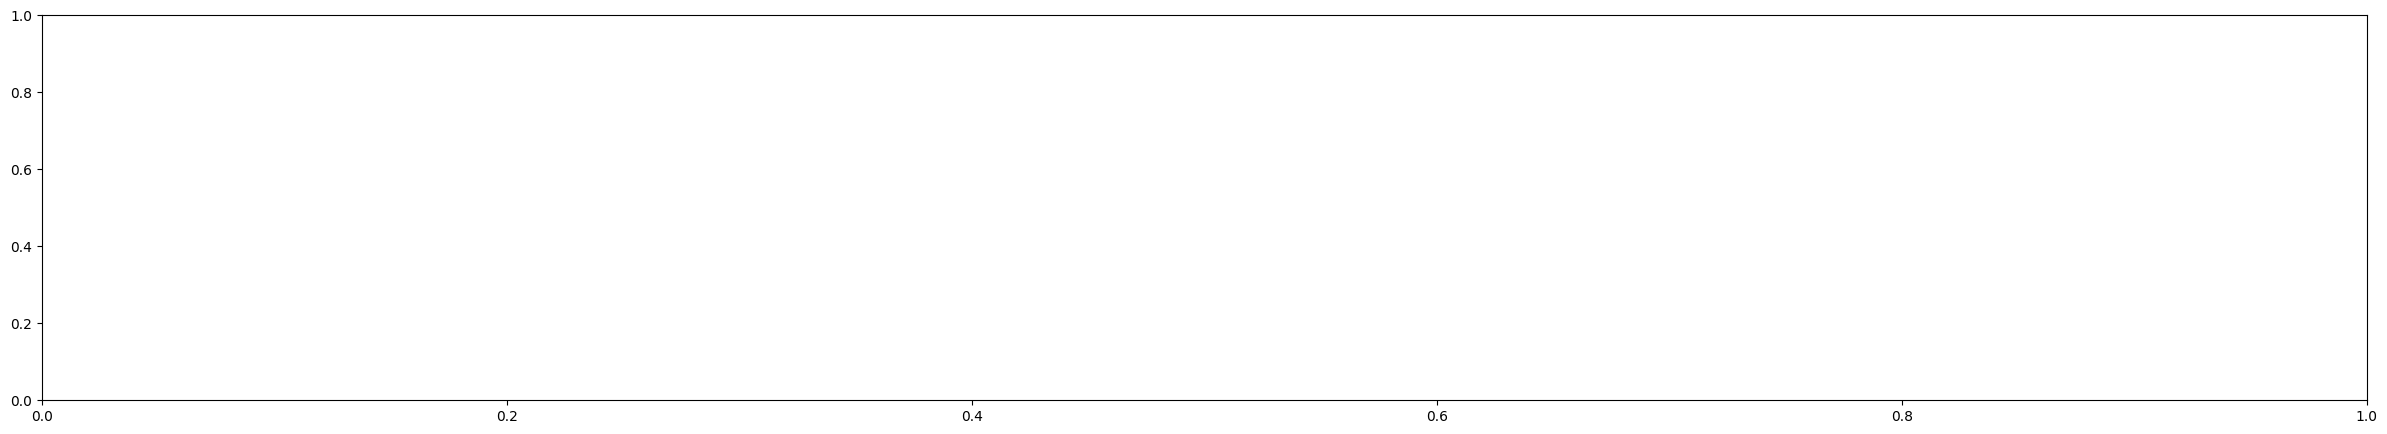

In [31]:
variables = [ 'test_color1', 
              'test_color2',  'test_color3',  'test_color4',  'test_color5', 
              'test_color6',  'test_color7',  'test_color8']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
    component = np.convolve(component, kernel, mode="same") 
    plt.plot(component[int(start[0]):end[-1]+10],label = var)
plt.vlines(s_on_train[0]-200,0,2,'r')
plt.vlines(s_on_train[0],0,2,'k')
plt.vlines(fix_on_train[0],0,2)
plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
variables = ['test_orient1', 
             'test_orient2', 'test_orient3', 'test_orient4']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
    
    plt.plot(component[int(start[0]):end[0]+10],label = var)
plt.vlines(s_on_train[0]-200,0,2,'r')
plt.vlines(s_on_train[0],0,2,'k')
plt.vlines(fix_on_train[0],0,2)
plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')

In [32]:
i_tr = 1
print("sample ID %d"%neu_data.sample_id[mask][i_tr])
print("test stimuli")
print(neu_data.test_stimuli[mask][i_tr])

sample ID 0
test stimuli
[15. 43. 11. 67.]


In [33]:
indices.keys()

dict_keys(['hist', 's_o1', 's_o5', 's_c1', 's_c5', 's_n0', 's_on_off', 'd_o1', 'd_o5', 'd_c1', 'd_c5', 'd_n0', 'd_on_off'])

KeyError: 'fix_cue'

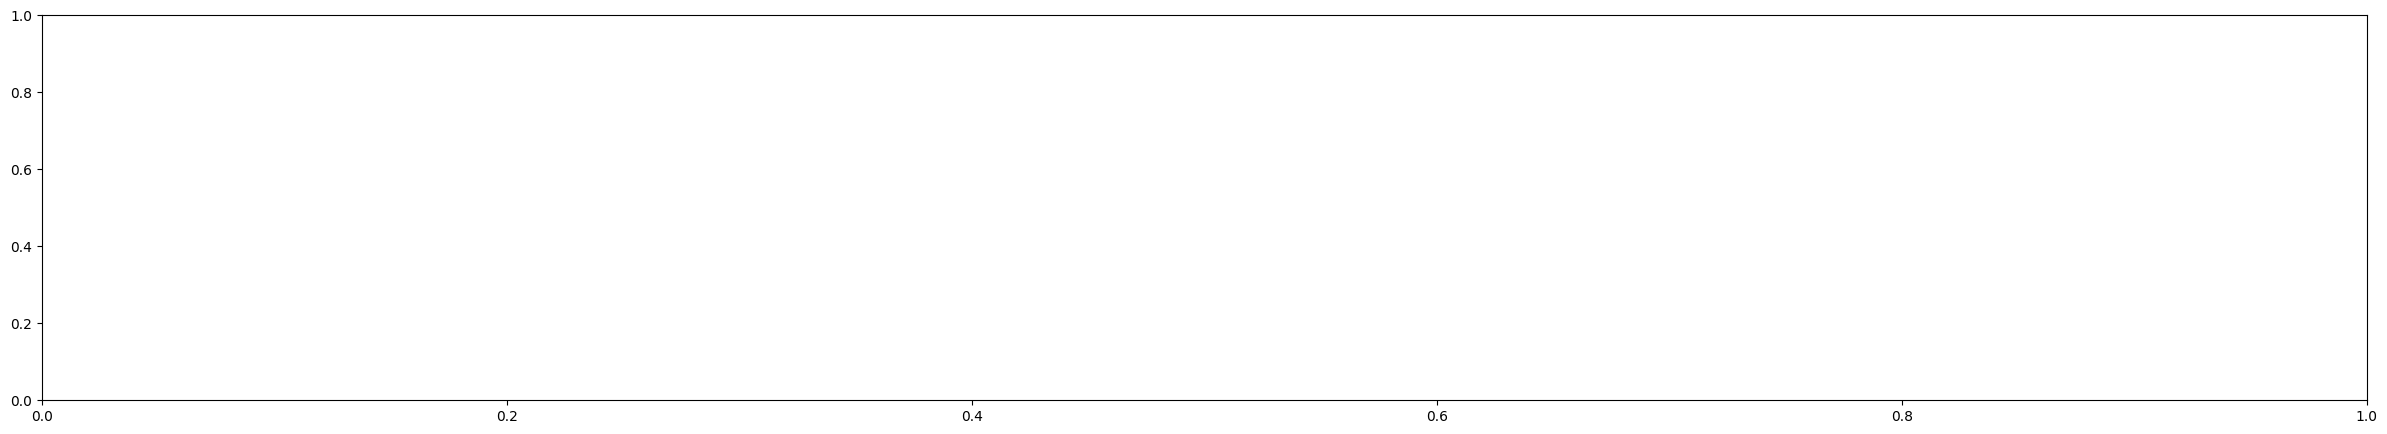

In [34]:
variables = ['fix_cue', 's_o1', 's_c5',  'd_o1', 'd_c5', 'test_orient1', 'test_orient8', 'test_orient5', 'test_color1', 'test_color5','match','bar_release']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
    plt.plot(component[int(start[i_tr]):end[i_tr]+100],label = var)
plt.vlines(neu_data.code_samples[mask][i_tr]-1000,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')

In [35]:
all_stim[i_tr]['bar_release'].sum()

KeyError: 'bar_release'

In [36]:
def get_component(var,dm,glm_vars,indices,start,end):
    st = indices[var][0]
    ed = indices[var][1]
    component= np.exp( dm[:,st:ed] @ glm_vars[var])
    return component[start:end]

In [43]:
all_components={}
# fixation
# var='fix_cue'
# # st = indices[var][0]
# # ed = indices[var][1]
# # component= np.exp( dm_train[:,st:ed] @ glm_vars[var])
# # all_components[var] = component[start[0]:end[0]]
# st = start[0]
# ed = end[0]
# all_components[var] = get_component(var,dm_train,glm_vars,indices,start=st,end=ed)
# # sample
t_befs= 0#400
vars = ['s_o1','s_o5','s_c1','s_c5','s_n0']
sampl_ids = [11,55,11,55,0]
for var, s_id in zip(vars,sampl_ids):
    idx=np.where(neu_data.sample_id[mask][idxs_train]==s_id)[0]
    st= int(start[idx[0]]+s_on_train[idx[0]]-t_befs)
    ed=end[idx[0]]
    all_components[var] = get_component(var,dm_train,glm_vars,indices,start=st,end=ed)
# delay
vars = ['d_o1','d_o5','d_c1','d_c5','d_n0']
t_befd = 400
sampl_ids = [11,55,11,55,0]
for var, s_id in zip(vars,sampl_ids):
    idx=np.where(neu_data.sample_id[mask][idxs_train]==s_id)[0]
    st= int(start[idx[0]]+d_on_train[idx[0]]-t_befd)
    ed=end[idx[0]]
    all_components[var] = get_component(var,dm_train,glm_vars,indices,start=st,end=ed)

Text(0.5, 0.98, 'Component')

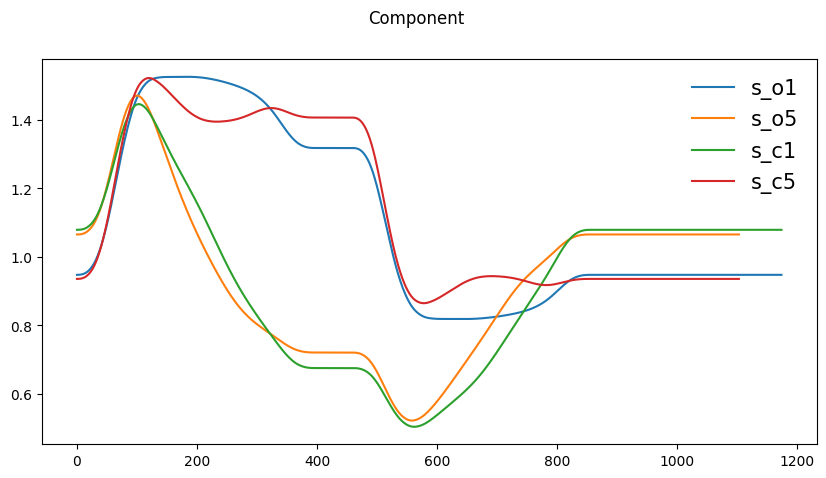

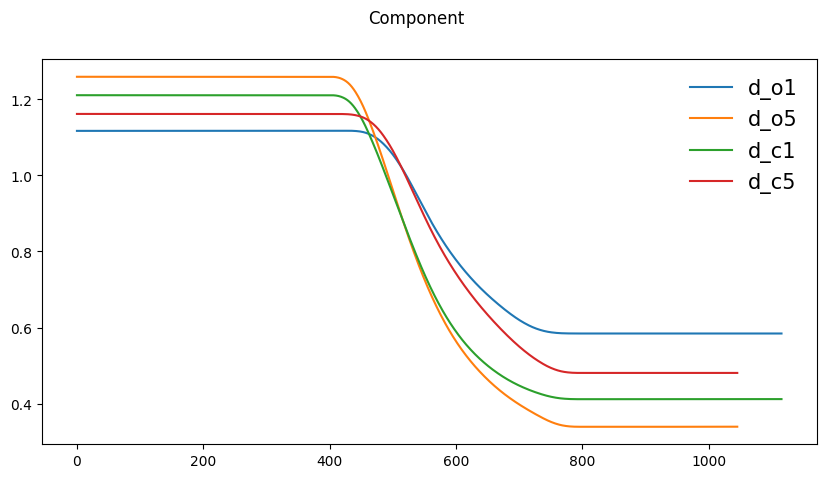

In [44]:
plt.subplots(figsize=(10,5))
for var in ['s_o1','s_o5','s_c1','s_c5']:
    comp = all_components[var]
    t=np.arange(len(comp[:]))
    
    plt.plot(t,comp[:],label=var)
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
plt.suptitle("Component")
plt.subplots(figsize=(10,5))
for var in ['d_o1','d_o5','d_c1','d_c5']:
    comp = all_components[var]
    t=np.arange(len(comp[:]))
   
    plt.plot(t,comp[:],label=var)
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
plt.suptitle("Component")
# #
# plt.subplots(figsize=(10,5))
# for var in [ 'test_color1','test_color2', 'test_color3',  'test_color4',  'test_color5',   'test_color7',  'test_color8']: #'test_color6',
#     comp = all_components[var]
#     t=np.arange(len(comp[200:-100]))-200
#     plt.plot(t,comp[200:-100],label=var)
# plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper left')
# plt.suptitle("Component")
# #
# plt.subplots(figsize=(10,5))
# for var in [ 'test_orient1','test_orient2', 'test_orient3',  'test_orient4',  'test_orient5',   'test_orient7',  'test_orient8']: #'test_color6',
#     comp = all_components[var]
#     t=np.arange(len(comp[200:-100]))-200
#     plt.plot(t,comp[200:-100],label=var)
# plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper left')
# plt.suptitle("Component")

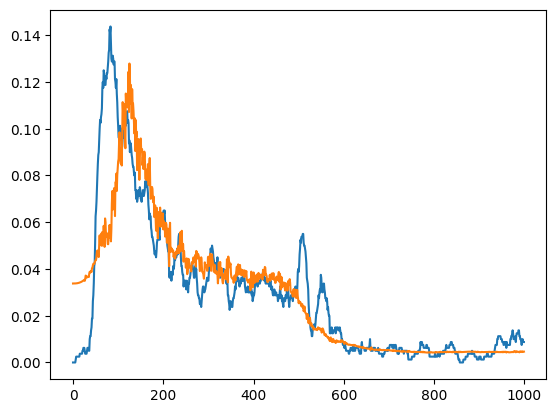

In [46]:
cumsum = np.cumsum(len_tr_train)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

predicted_tr = []
for i_tr in range(s_on_train.shape[0]):
    st=int(s_on_train[i_tr])
    predicted_tr.append(rate_pred_train[start[i_tr]:end[i_tr]][st:int(st+1000)])
no_neu = np.where(neu_data.sample_id[mask][idxs_train][:s_on_train.shape[0]]!=0)[0]

sp_tr = []
for i_tr in range(s_on_train.shape[0]):
    st=int(s_on_train[i_tr])
    dat = sp_train[start[i_tr]:end[i_tr]]
    sp_tr.append(firing_rate.moving_average(data=dat, win=20, step = 1)[st:int(st+1000)])

plt.plot(np.array(sp_tr)[no_neu].mean(axis=0))
plt.plot(np.array(predicted_tr)[no_neu].mean(axis=0))

In [47]:
cumsum = np.cumsum(len_tr_test)
cumsum=np.concatenate(([0],cumsum))
start_test = cumsum[:-1]
end_test = cumsum[1:]

In [48]:

predicted_tr = []
for i_tr in range(s_on_test.shape[0]):
    st=int(s_on_test[i_tr]-200)
    predicted_tr.append(rate_pred_test[start_test[i_tr]:end_test[i_tr]][st:int(st+200+1000)])
no_neu = np.where(neu_data.sample_id[mask][idxs_test]!=0)[0]

sp_tr = []
for i_tr in range(s_on_test.shape[0]):
    st=int(s_on_test[i_tr]-200)
    dat = sp_test[start_test[i_tr]:end_test[i_tr]]
    sp_tr.append(firing_rate.moving_average(data=dat, win=20, step = 1)[st:int(st+200+1000)])

plt.plot(np.array(sp_tr)[no_neu].mean(axis=0))
plt.plot(np.array(predicted_tr)[no_neu].mean(axis=0))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (25,) + inhomogeneous part.

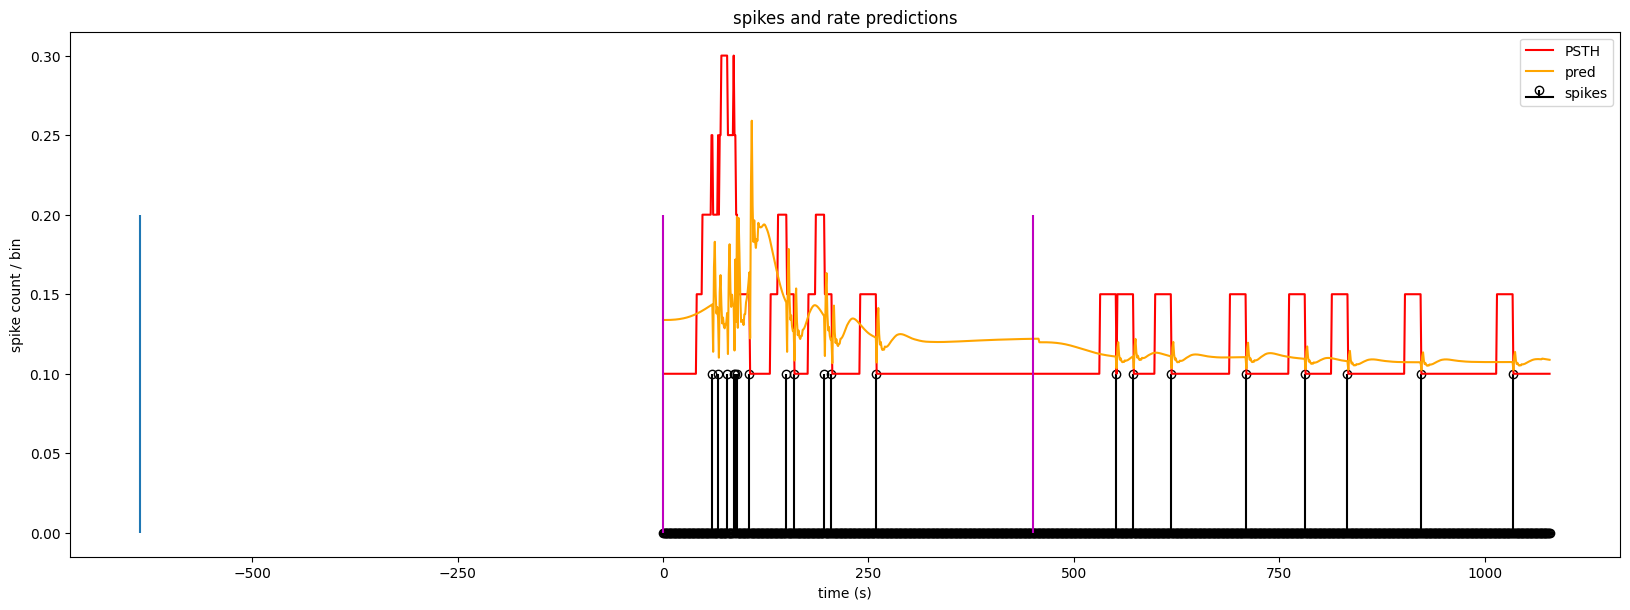

In [49]:
# Compute predicted spike rate on training data
#rate_pred = np.exp(glm_const + dm_train@ glm_result.params[1:])
it=40
t_start,t_end=start[it],end[it]
# Make plot
fig = plt.figure(figsize=[20,15])
iiplot = np.arange(0,t_end-t_start)
ttplot = iiplot*1
plt.subplot(212)
markerline,_,_ = plt.stem(ttplot, sp_train[t_start:t_end][iiplot]/10, linefmt='k-', basefmt='k-', label='spikes')
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'k')
dat= sp_train[t_start:t_end]
plt.plot(ttplot,firing_rate.moving_average(data=dat, win=20, step = 1)+0.1, c='red', label='PSTH')
plt.plot(ttplot,rate_pred_train[t_start:t_end]+0.1, c='orange', label='pred')

_=plt.vlines(s_on_train[it],0,0.2,'m')
_=plt.vlines(s_on_train[it]+450,0,0.2,'m')
_=plt.vlines(fix_on_train[it],0,0.2)

plt.legend()
plt.xlabel('time (s)')
plt.title('spikes and rate predictions')
plt.ylabel('spike count / bin')
plt.show()